Concours HC18 sur [Grand Challenge](https://hc18.grand-challenge.org/Home/)

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers, activations

# Conception du Model

### Conception du RésidualUnit

In [3]:
class ResidualUnit(layers.Layer):
  def __init__(self, filters, strides=1, activation='relu', drop=0., change_filters=False, **kwargs):
    super().__init__(**kwargs)
    self.drop = drop
    self.activation = activations.get(activation)
    self.main_layers = [
        layers.Conv2D(filters, 3, strides=1, padding='same'),
        self.activation,
        layers.Dropout(self.drop),
        layers.Conv2D(filters, 3, strides=strides, padding='same')]
    self.skip_layers = []
    if strides > 1:
      self.skip_layers = [layers.Conv2D(filters, 1, strides=strides, padding='same')]
    elif change_filters:
      self.skip_layers = [layers.Conv2D(filters, 1, strides=1, padding='same')]
    
  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
      skip_Z = layer(skip_Z)
    add = Z + skip_Z
    add = layers.Dropout(self.drop)(add)
    add = self.activation(add)
    add = layers.BatchNormalization()(add)
    return add

### Création du bloc Residual

In [4]:
def New_Bloc(model, number, coeff, inter_layer_size, drop, final_stride=2):
  model.add(ResidualUnit(coeff*number, drop=drop, change_filters=True))
  for i in range(inter_layer_size):
    model.add(ResidualUnit(coeff*number, drop=drop))
  model.add(ResidualUnit(coeff*number, strides=final_stride, drop=drop))
  return model

### Architecture du model

In [5]:
def Resnet(number, width=200, height=135):
  model = models.Sequential()
  model.add(layers.Input(shape=(width, height, 1), dtype='float32'))
  
  model = New_Bloc(model, number, coeff=2,  inter_layer_size=2,  drop=0.3 )
  model = New_Bloc(model, number, coeff=4,  inter_layer_size=5,  drop=0.4 )
  model = New_Bloc(model, number, coeff=8,  inter_layer_size=11, drop=0.4 )
  model = New_Bloc(model, number, coeff=16, inter_layer_size=22, drop=0.5, final_stride=1)

  model.add(layers.GlobalAvgPool2D())
  model.add(layers.Flatten())
  model.add(layers.Dense(5, activation='sigmoid'))
  return model

In [6]:
model = Resnet(8)     

# Data Processing

In [7]:
TRAIN_PATH = '/content/drive/MyDrive/HollowOak/Concours_HC18/training_set/'
TEST_PATH = '/content/drive/MyDrive/HollowOak/Concours_HC18/test_set/'
WORK_PATH = '/content/drive/MyDrive/HollowOak/Concours_HC18/'
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import random
import h5py
import csv
import cv2
import os
np.random.seed(24)
random.seed(24)

### Pré-traitement 

- Fonctions de pré-traitement des images

In [8]:
def rotateImage(image, angle):
  image_center=tuple(np.array(image.shape[1::-1])/2) # [1::-1]---> interversion de la hauteur et largeur pour cv2
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  rotated = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return rotated

def noise(image):
  h, w, c = image.shape
  noise = np.random.randn(h, w, c)*random.randint(1, 50)
  return np.clip(image+noise, 0, 255).astype(np.uint8)

def smaller_but_resized(image, ellipse, width=135, height=200, shift=True):
  if shift:
    h, w, c = image.shape
    H, W = int(1.4*h), int(1.4*w)
    h_shift = np.random.randint(H - h)
    w_shift = np.random.randint(W - w)
    # Tranlation de l'image
    board = np.zeros((H, W, c), dtype=np.uint8)
    board[h_shift : h_shift+h, w_shift: w_shift+w, :] = image
    image = board
    # Translation de l'ellipse
    board = np.zeros((H, W, c), dtype=np.uint8)
    board[h_shift : h_shift+h, w_shift: w_shift+w, :] = ellipse
    ellipse = board
  # Redimensionnement
  image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)
  ellipse = cv2.resize(ellipse, (width, height), interpolation=cv2.INTER_AREA)
  return image, ellipse

### Extraction de caractéristiques

- Fonction de récupération des caractéristiques des ellipses

In [9]:
def collect_features(image, ellipse, images_set, labels_set, maxi=200):
  contours, hierarchy = cv2.findContours(ellipse[:, :, 0], 
                                         cv2.RETR_LIST, 
                                         cv2.CHAIN_APPROX_SIMPLE)
  if len(contours) is not 2:
    return 1  # Contours interne et externe seulement sinon --> out
  elif min(len(contours[0]), len(contours[1])) < 6:
    return 1  # Les contours doivent contenir assez de points sinon --> out
  
  # Caractéristiques des ellipses
  (x1, y1), (small_1, major_1), angle_1 = cv2.fitEllipse(contours[0])  
  (x2, y2), (small_2, major_2), angle_2 = cv2.fitEllipse(contours[1])
  # Moyenne des caractéristiques des 2 ellipses
  x, y = (x1+x2)/2, (y1+y2)/2
  small, major = (small_1+small_2)/2, (major_1+major_2)/2
  angle = (angle_1+angle_2)/2

  images_set.append(image[:, :, 0])
  labels_set.append([elt/maxi for elt in [x, y, major, small]] + [angle/180])
  return 0

### Traitement des données

- Fonction de lecture et de traitement des données

In [10]:
file = '/content/drive/MyDrive/HollowOak/Concours_HC18/training_set_pixel_size_and_HC.csv'
def process(file):
  with open(file, newline='') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    next(lines)
    images_set = []
    labels_set = []
    rejected = 0
    for line in lines:  # Une image, une ellipse
      image = cv2.imread(TRAIN_PATH + line[0])
      ellipse_path = line[0].split('.')[0] + '_Annotation.png'
      ellipse = cv2.imread(TRAIN_PATH + ellipse_path)
      # Augmentation des données
      new_image, new_ellipse = smaller_but_resized(image, ellipse)
      image, ellipse = smaller_but_resized(image, ellipse, shift=False)
      for angle in range(0, 360, 30):
        luck = np.random.randint(2)
        temp_img, temp_ellipse = [(image, ellipse), 
                                  (new_image, new_ellipse)][luck]
        
        temp_img = rotateImage(temp_img, angle)
        temp_img = noise(temp_img)
        temp_ellipse = rotateImage(temp_ellipse, angle)
        rejected += collect_features(temp_img, temp_ellipse, 
                                     images_set, labels_set)
        for i in [0, 1, -1]:
          flip_img = cv2.flip(temp_img, i)
          flip_ellipse = cv2.flip(temp_ellipse, i)
          rejected += collect_features(flip_img, flip_ellipse, 
                                       images_set, labels_set)
  print('Rejected images:', rejected)
  print('images_set_size', len(images_set))
  return images_set, labels_set   

### Elaboration du dataset

- Obtention du jeu étiqueté

In [11]:
# Une bonne dizaine de minutes
images_set, labels_set = process(file)

Rejected images: 9288
images_set_size 38664


In [12]:
images_set = np.array(images_set, dtype=np.float32)/255
labels_set = np.array(labels_set, dtype=np.float32)
# Mélange du jeu d'entrainement
index = np.random.permutation(len(images_set))
images_set = images_set[index].reshape(-1, 200, 135, 1)
labels_set = labels_set[index]

- Sauvegarde des données (optionnel)

In [17]:
# Sauvegarde des données
os.chdir(WORK_PATH)
h5f = h5py.File('data.h5', 'w')
h5f.create_dataset('images_set', data=images_set)
h5f.create_dataset('labels_set', data=labels_set)
h5f.close()

In [11]:
# Restauration des données
os.chdir(WORK_PATH)
data = h5py.File('data.h5', 'r')
images_set = data['images_set']
labels_set = data['labels_set']

- Finalisation dataset

In [12]:
train_set = tf.data.Dataset.from_tensor_slices((images_set, labels_set)).batch(64)
del images_set
del labels_set

# Configuration de l'entrainement

### Fonctions et hypermaramètres

- Perte inspirée de l'architecture [Yolo](https://arxiv.org/pdf/1506.02640.pdf) (page_4)

In [13]:
def Yolo_loss(labels, predictions):
    lambda_xy=5
    lambda_Ms=5
    lambda_angle=1
    # Prédictions 
    coord_pred = predictions[:, 0:2]
    major_small_pred = predictions[:, 2:4]
    angle_pred = predictions[:, 4]
    # Labels 
    coord_xy = labels[:, 0:2]
    major_small_axis = labels[:, 2:4]
    angle = labels[:, 4]
    # Loss 
    loss_xy = tf.reduce_sum(tf.math.square(coord_pred - coord_xy), axis=-1)
    loss_Ms = tf.reduce_sum(tf.math.square(major_small_pred - major_small_axis), axis=-1)
    loss_angle = tf.math.square(angle_pred - angle)
    loss = (lambda_xy*loss_xy) + (lambda_Ms*loss_Ms) + (lambda_angle*loss_angle)
    return loss

- Fonctions d'entrainement habituelles

In [ ]:
#@tf.function  ---> Incompatible pour l'instant, revoir l'implémentation 
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = Yolo_loss(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  train_loss(loss)

def train(train_set, epochs):
    for epoch in range(epochs):
        for images, labels in train_set:
            train_step(images, labels)
        template = 'Entrainement {:04d}: train_loss: {:6.4f}'
        print(template.format(epoch+1, train_loss.result()))
        if not epoch % 5:
          save_path = './training/'
          checkpoint.save(file_prefix=save_path)

- Optimizer, perte et checkpoint

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1E-4)
checkpoint = tf.train.Checkpoint(model=model)
train_loss = tf.keras.metrics.Mean()

### Entrainement

In [15]:
# Pour gagner du temps, nous n'utilisons pas de set de validation pendant l'entrainement:
# voir d'abord si la fonction small_but_resized impacte favorablement la qualité des prédictions
train(train_set, epochs=30)

Entrainement 0001: train_loss: 0.1966
Entrainement 0002: train_loss: 0.1379
Entrainement 0003: train_loss: 0.1127
Entrainement 0004: train_loss: 0.0976
Entrainement 0005: train_loss: 0.0872
Entrainement 0006: train_loss: 0.0794
Entrainement 0007: train_loss: 0.0734
Entrainement 0008: train_loss: 0.0684
Entrainement 0009: train_loss: 0.0643
Entrainement 0010: train_loss: 0.0610
Entrainement 0011: train_loss: 0.0581
Entrainement 0012: train_loss: 0.0556
Entrainement 0013: train_loss: 0.0532
Entrainement 0014: train_loss: 0.0511
Entrainement 0015: train_loss: 0.0493
Entrainement 0016: train_loss: 0.0475
Entrainement 0017: train_loss: 0.0458
Entrainement 0018: train_loss: 0.0443
Entrainement 0019: train_loss: 0.0429
Entrainement 0020: train_loss: 0.0415
Entrainement 0021: train_loss: 0.0402
Entrainement 0022: train_loss: 0.0391
Entrainement 0023: train_loss: 0.0379
Entrainement 0024: train_loss: 0.0369
Entrainement 0025: train_loss: 0.0360
Entrainement 0026: train_loss: 0.0350
Entrainement

### Save/Import modèle

In [16]:
# Sauvegarde des derniers poids
model.save_weights(WORK_PATH)

In [ ]:
# Restauration des poids
#model = Resnet(8)
#model.load_weights(WORK_PATH)

In [ ]:
# Restaurer le modèle à l'instant t
#checkpoint.restore(tf.train.latest_checkpoint("./training/", '-3.data-00000-of-00001'))

# Inférence

### Prédictions sur le jeu test

In [17]:
file = '/content/drive/MyDrive/HollowOak/Concours_HC18/test_set_pixel_size.csv'
with open(file, newline='') as csvfile:
  lines = csv.reader(csvfile, delimiter=',')
  next(lines)
  test_inferences = []
  for line in lines:
    image = cv2.imread(TEST_PATH+line[0])
    H, W, C = image.shape
    mm_pixel = float(line[1])
    resized = cv2.resize(image, (135, 200))
    resized_copy = resized.copy()
    # Normalisation pour l'inférence
    resized = np.array(resized, dtype=np.float32)/255
    resized = np.expand_dims(resized[:, :, 0], axis=-1)
    predictions = model(np.array([resized]))
    x, y, major, small, angle = predictions[0]
    cv2.ellipse(resized_copy, (x*200, y*200), (small*200/2, major*200/2), angle*180, 0., 360., (0, 0, 255), 2)
    test_inferences.append(resized_copy)

In [18]:
print('test_inferences: {} inférences'.format(len(test_inferences)))

test_inferences: 335 inférences


### Visualisation

- Observation de 21 inférences (foetus et ellipse)

In [21]:
# Nos 21 inférences
random_sample_indices = [np.random.randint(335) for _ in range(21)]

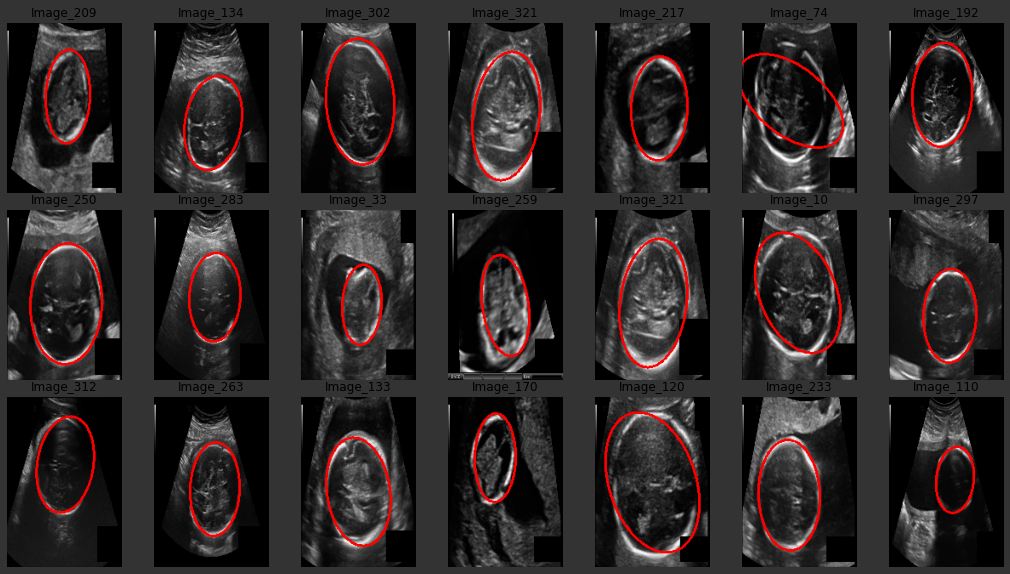

In [26]:
fig = plt.figure(figsize=(18, 10))
fig.patch.set_facecolor('0.2')
fig.subplots_adjust(hspace=0.1)
for _, indice in enumerate(random_sample_indices):
  plt.subplot(3, 7, _+1)
  plt.axis('off')
  plt.title('Image_{}'.format(indice))
  plt.imshow(test_inferences[indice][:, :, ::-1])
plt.show()

# Conclusion

### Premières remarques importantes

- Ce que l'on observe

In [ ]:
"""
--->Bonnes prédictions sur les foetus de petite taille
   (petite relativement aux dimmensions de l'image)

--->Certaines prédictions à coté de la plaque pour les foetus 
    de grandes tailles. Des fois parfaites au contraire... 
    (voir ici dessous pour des mauvaises prédictions)
"""

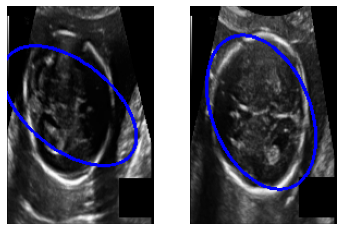

In [27]:
plt.figure()
plt.subplot(121)
plt.axis('off')
plt.imshow(test_inferences[74])
plt.subplot(122)
plt.axis('off')
plt.imshow(test_inferences[10])
plt.show()

## Suppositions

- Constat

In [ ]:
"""
La fonction 'small_but_resized' avait pour objectif d'effectuer une mise à l'echelle 
(une fois sur deux) avant de redimensionner toutes les images aux mêmes dimensions.
---> L'intérêt était d'améliorer la qualité des inférences faites sur les petits foetus,
    en fournissant davantage d'images à échelle réduite: maintenant le contraire se produit...
"""

- Mon hypothèse principale

In [ ]:
"""
Lors de la phase d'augmentation des données, des rotations successives sont effectuées sur
l'ensemble du jeu d'entrainement. Mais il y a un piège.

---> Sur les images associées à de grandes ellipses, l'ellipse sort du champ de l'image:
    En conséquence, la fonction 'fitEllipse' d'openCV ne parvient pas à 
    capturer ses dimensions convenablement, et l'image ne passe pas le test de fiabilité.
    
    L'image atteri dans les 1/5 d'images rejetées ce qui déséquilibre le dataset en faveur
    des ellipses plus petites.
    Au final, un entrainement plus intensif n'aurait eu pour effet que d'accentuer le trait
    en surajustant les petits foetus au détriment des plus grands sur l'image.

"""

## Mesures à prendre

In [ ]:
"""
Il faudrait sans doute effectuer un autre traitement sur les images qui ne passent
pas le test de fiabilité après rotation, en les capturant au lieu de les écarter.

Surtout qu'il s'agit probablement d'une majorité de foetus de grande taille:
on pourrait se contenter d'effectuer des transformations n'incluant pas des rotations,
comme des symétries par exemples.

C'est d'autant plus judicieux qu'il existe une grande diversité de localisations pour les foetus de petite 
taille (les rotations sont donc bienvenues), alors que les foetus qui occupe toute l'image ont 
quasiment la même orientation, car on sait que l'image contient toujours la totalité du foetus 
(rotations inutiles pour l'apprentissage du réseau au final).

Bilan:
Prendre en compte tout cela pour une éventuelle deuxième version!

"""

- Fin